In [1]:
import os
import shutil
import time
import pandas as pd
import numpy as np
import seaborn as sns
from functools import reduce
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import pyspark.sql.functions as F
from pyspark.mllib.stat import Statistics

In [2]:
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession \
    .builder \
    .appName("Python Spark regression example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [4]:
# load dataset
data = spark.read.csv(path='../data/credit_example.csv',
                      sep=',', encoding='UTF-8', comment=None, header=True, inferSchema=True)

In [5]:
data.limit(10).toPandas()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,247408,0,Cash loans,F,Y,N,2,108000.0,172512.0,13477.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,153916,0,Revolving loans,F,Y,Y,2,135000.0,180000.0,9000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,229065,0,Cash loans,F,N,Y,0,112500.0,463500.0,20547.0,...,0,0,0,0,0.0,0.0,1.0,0.0,0.0,7.0
3,282013,0,Cash loans,F,N,Y,0,135000.0,549882.0,17739.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
4,142266,0,Cash loans,F,N,Y,0,90000.0,518562.0,20695.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
5,330221,0,Cash loans,F,Y,N,0,157500.0,550980.0,40221.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
6,171519,0,Cash loans,F,N,Y,0,126000.0,770292.0,35824.5,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0
7,385229,0,Cash loans,F,N,Y,0,270000.0,532494.0,30699.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0
8,273675,0,Cash loans,F,N,Y,0,112500.0,458725.5,17707.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
9,171005,0,Cash loans,M,Y,Y,0,135000.0,175896.0,9108.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
from AutoFeatures import AutoFeatures

In [7]:
indexCol = 'SK_ID_CURR'
labelCol = 'TARGET'

task = 'classification'

In [8]:
# unique_selector 
to_drop = AutoFeatures.unique_selector(data, tracking=True)
print('unique_selector::{}'.format(to_drop))

Unique selector took = 26.200870275497437 s
unique_selector::['FLAG_MOBIL', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_17']


Missing selector took = 13.758307456970215 s


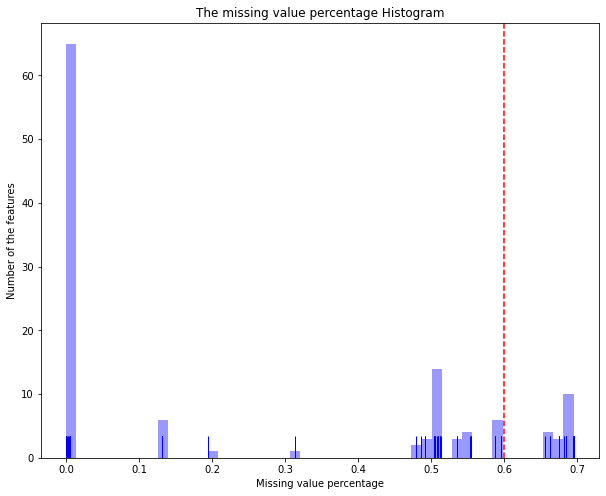

unique_selector::['OWN_CAR_AGE', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'FLOORSMIN_AVG', 'LIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_AVG', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'FLOORSMIN_MODE', 'LIVINGAPARTMENTS_MODE', 'NONLIVINGAPARTMENTS_MODE', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'FLOORSMIN_MEDI', 'LIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'FONDKAPREMONT_MODE']


In [9]:
# missing_selector 
to_drop = AutoFeatures.missing_selector(data, display=True, tracking=True)
print('unique_selector::{}'.format(to_drop))

Correlation selector took = 30.143810749053955 s


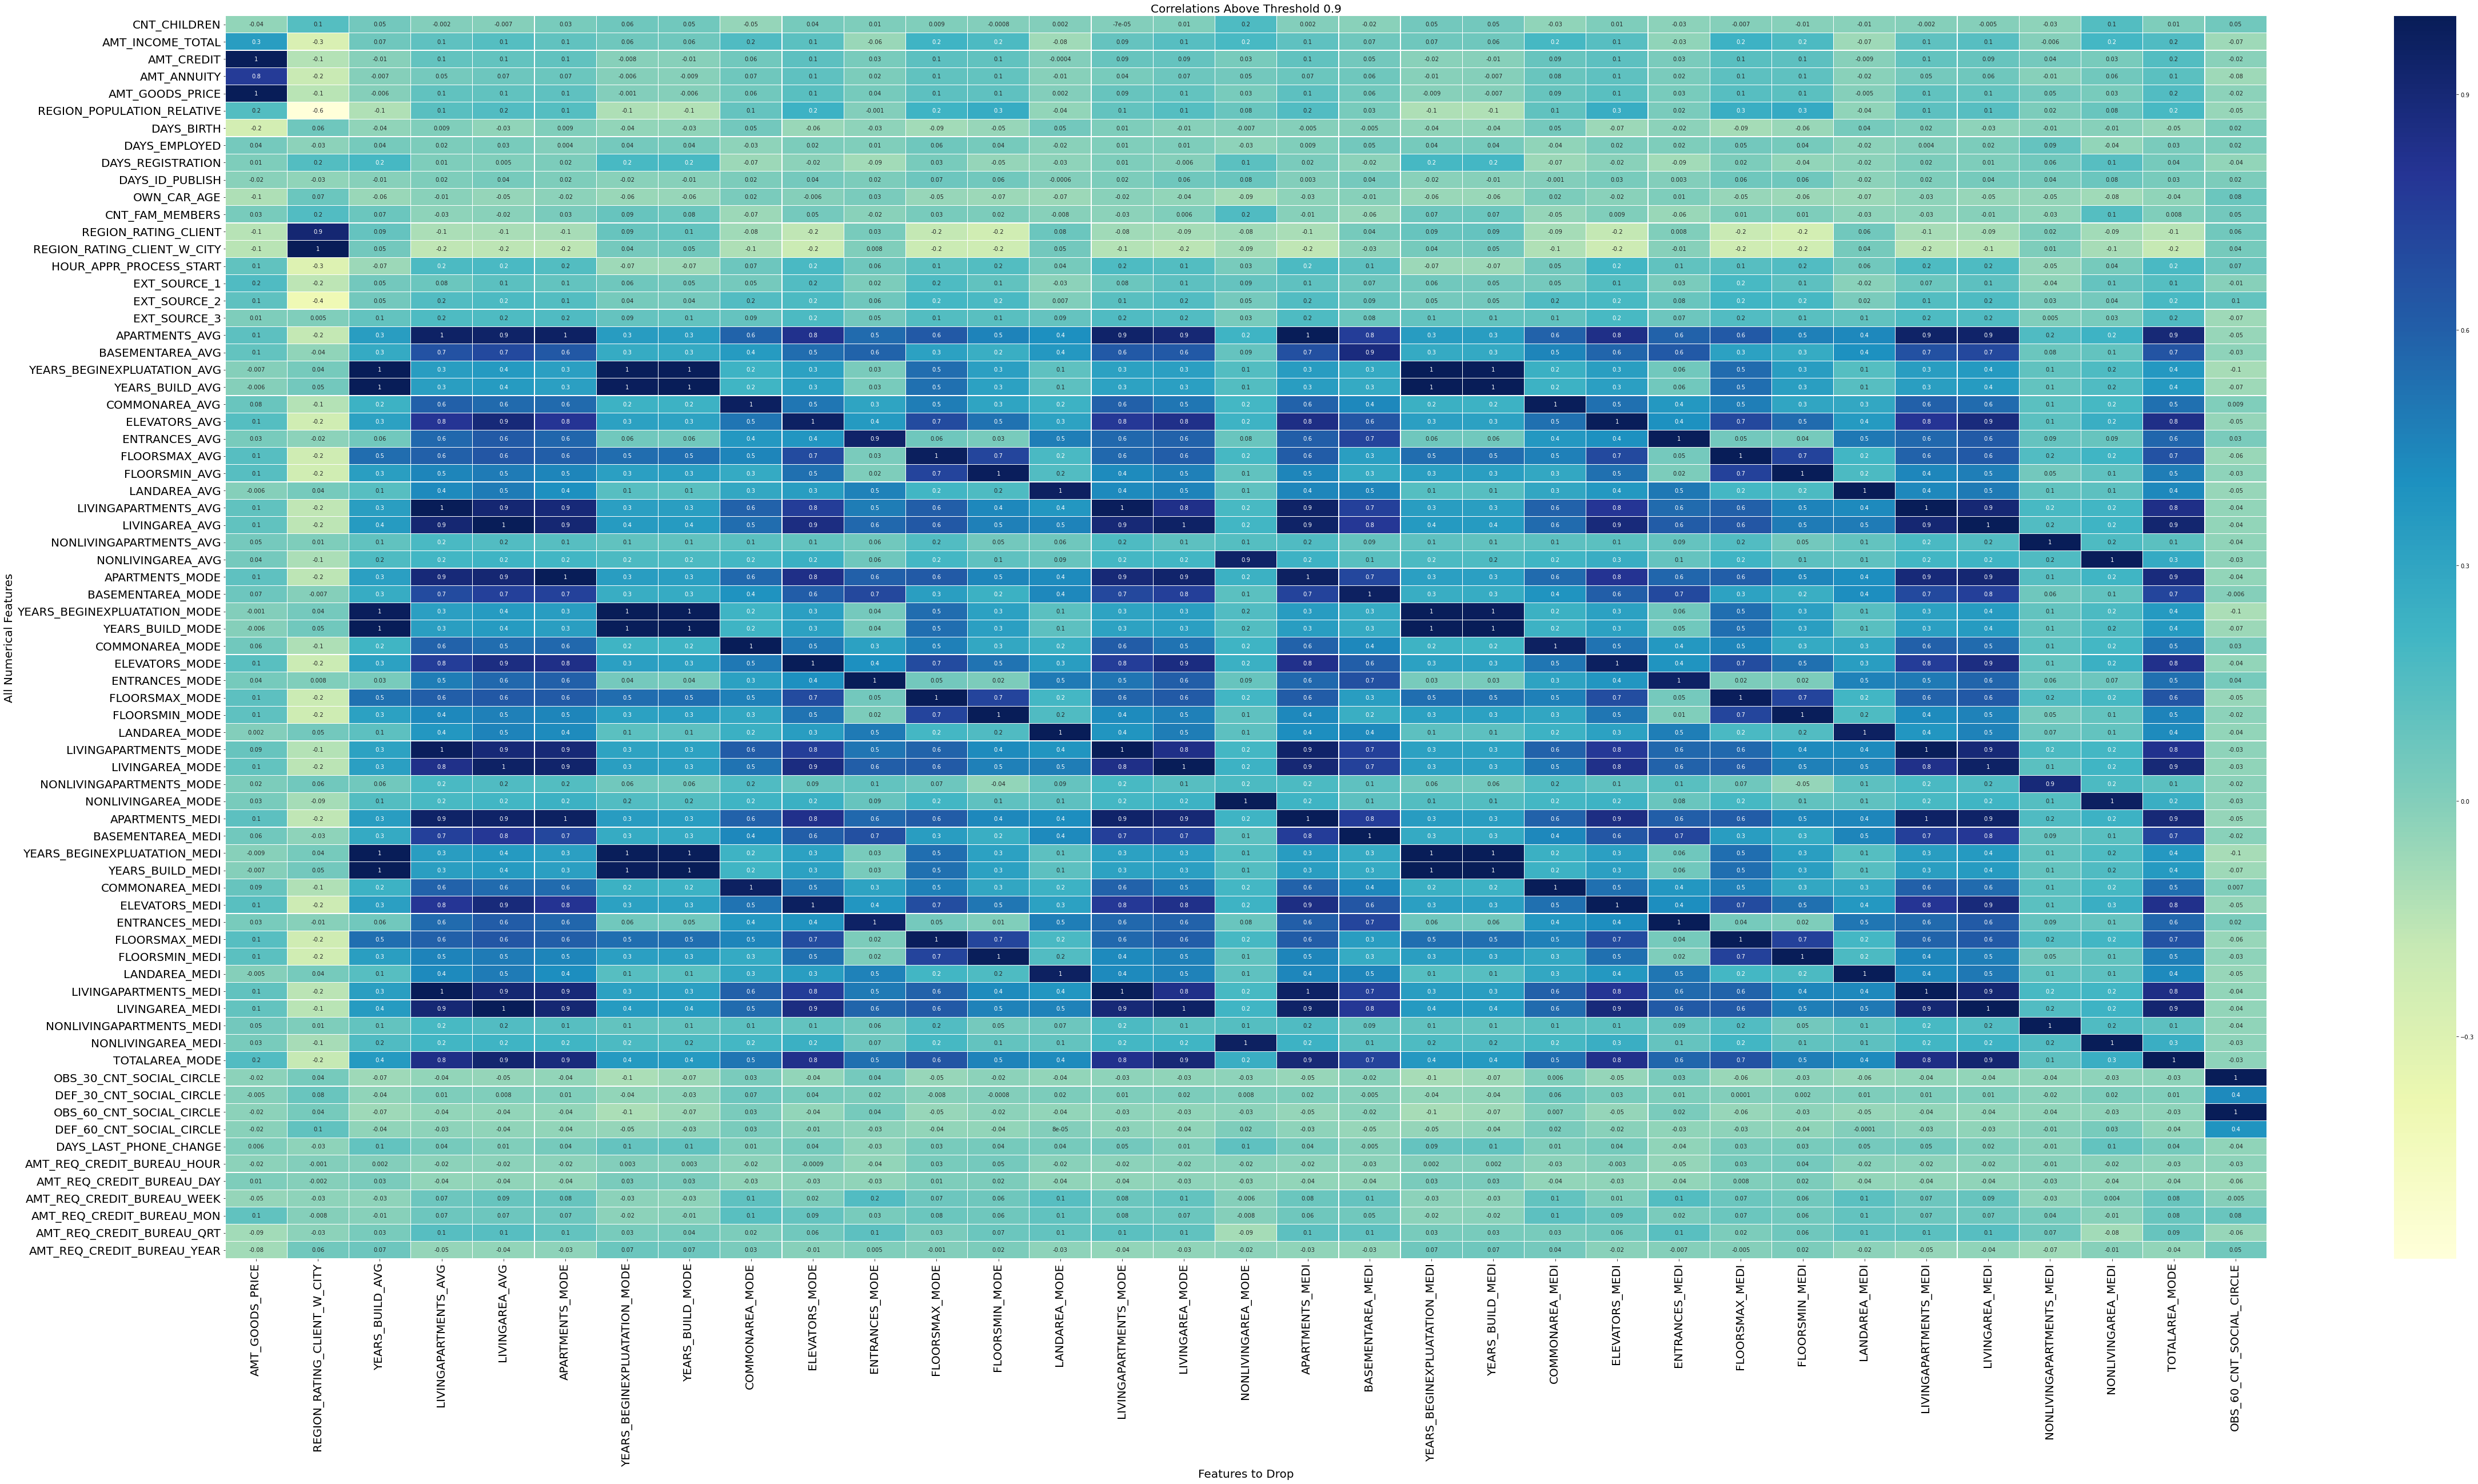

corr_selector::['AMT_GOODS_PRICE', 'REGION_RATING_CLIENT_W_CITY', 'YEARS_BUILD_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'APARTMENTS_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'TOTALAREA_MODE', 'OBS_60_CNT_SOCIAL_CIRCLE']


In [10]:
# correlation selector
to_drop = AutoFeatures.corr_selector(data, index_col=indexCol, label_col=labelCol,
                           corr_thold=0.9, method="pearson", rotation=True,
                           display=True, tracking=True, cat_num=2)
print('corr_selector::{}'.format(to_drop))

Unique selector took = 24.582699298858643 s
Missing selector took = 14.54124665260315 s


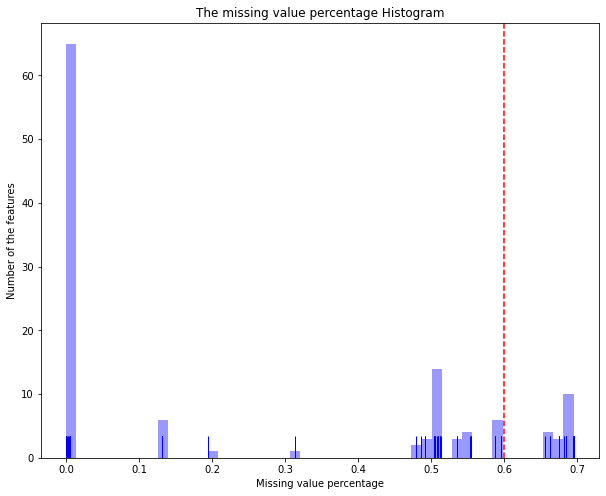

Correlation selector took = 29.05739450454712 s


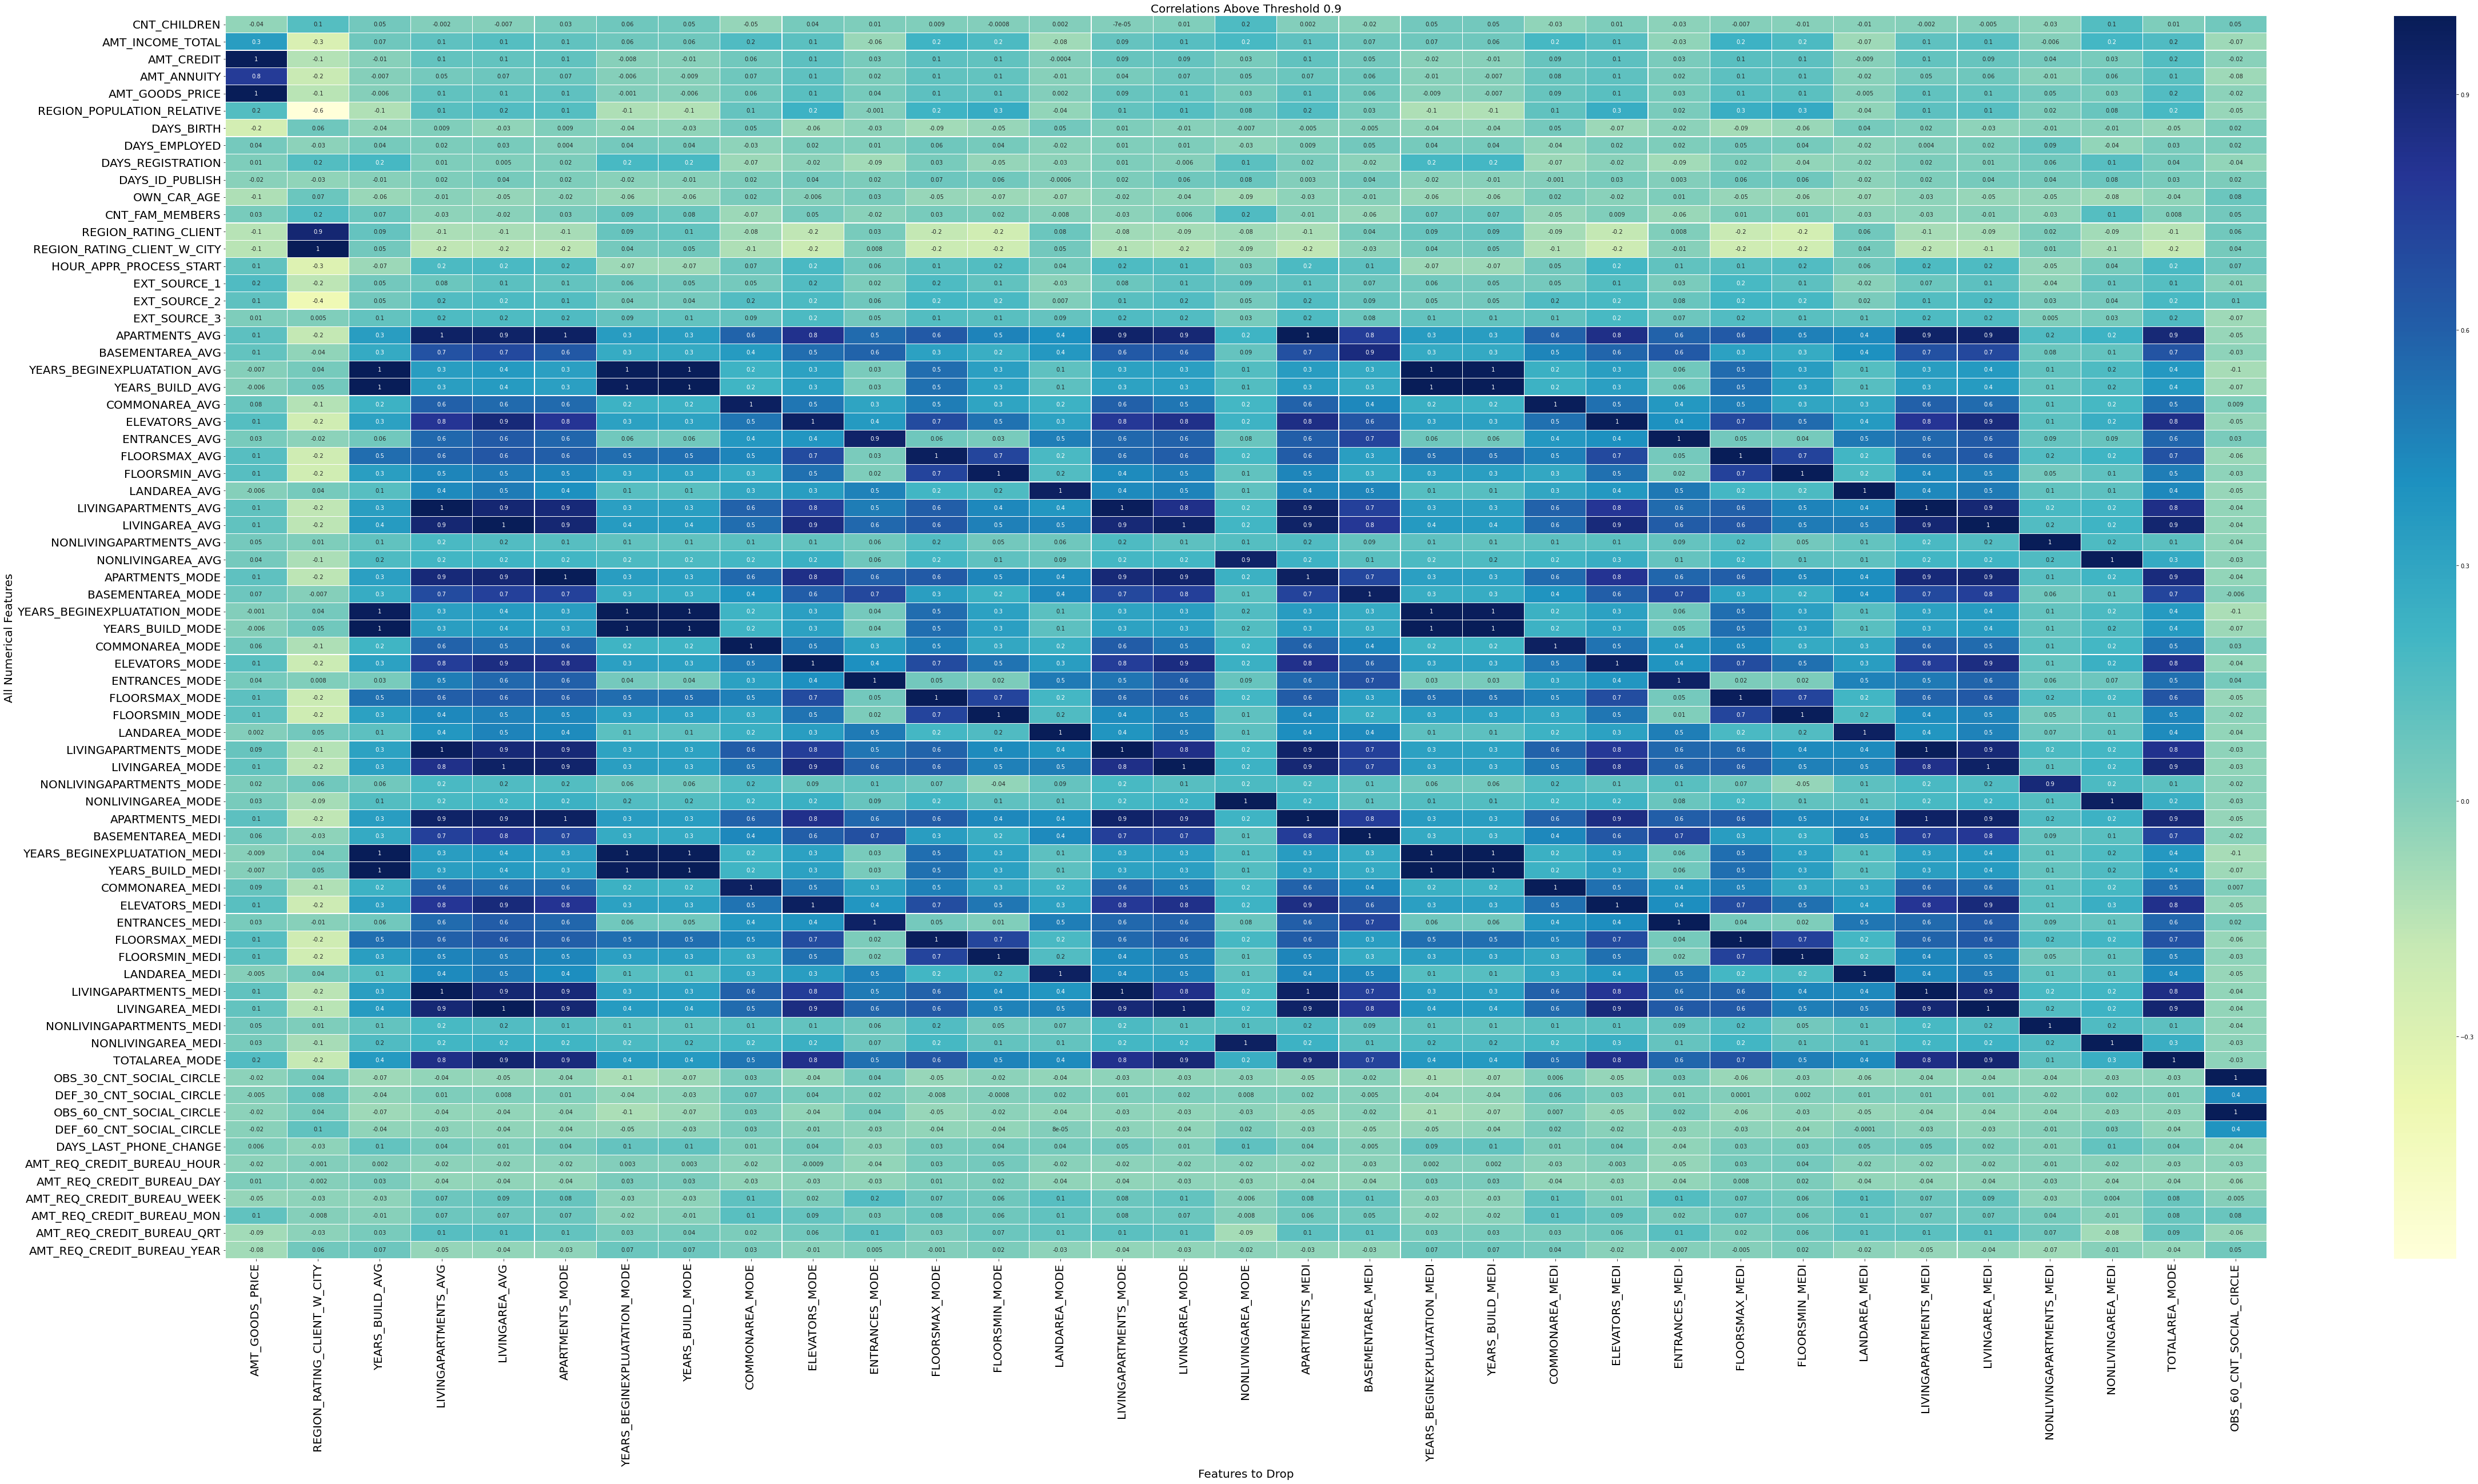

The essential selector took = 75.73068141937256 s
essential_drop: ['FLAG_MOBIL', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_17', 'AMT_GOODS_PRICE', 'REGION_RATING_CLIENT_W_CITY', 'YEARS_BUILD_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'APARTMENTS_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'TOTALAREA_MODE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'OWN_CAR_AGE', 'COMMONAREA_AVG', 'FLOORSMIN_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_MODE', 'FONDKAPREMONT_MODE']


In [11]:
# essential_drop test
to_drop = AutoFeatures.essential_drop(data, index_col=indexCol, label_col=labelCol, display=True, tracking=True)
print('essential_drop: {}'.format(to_drop))

Unique selector took = 24.51390027999878 s
Missing selector took = 12.491259098052979 s


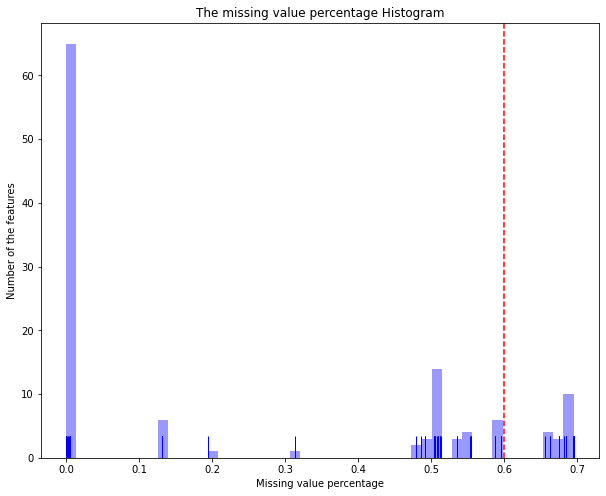

Correlation selector took = 27.003296613693237 s


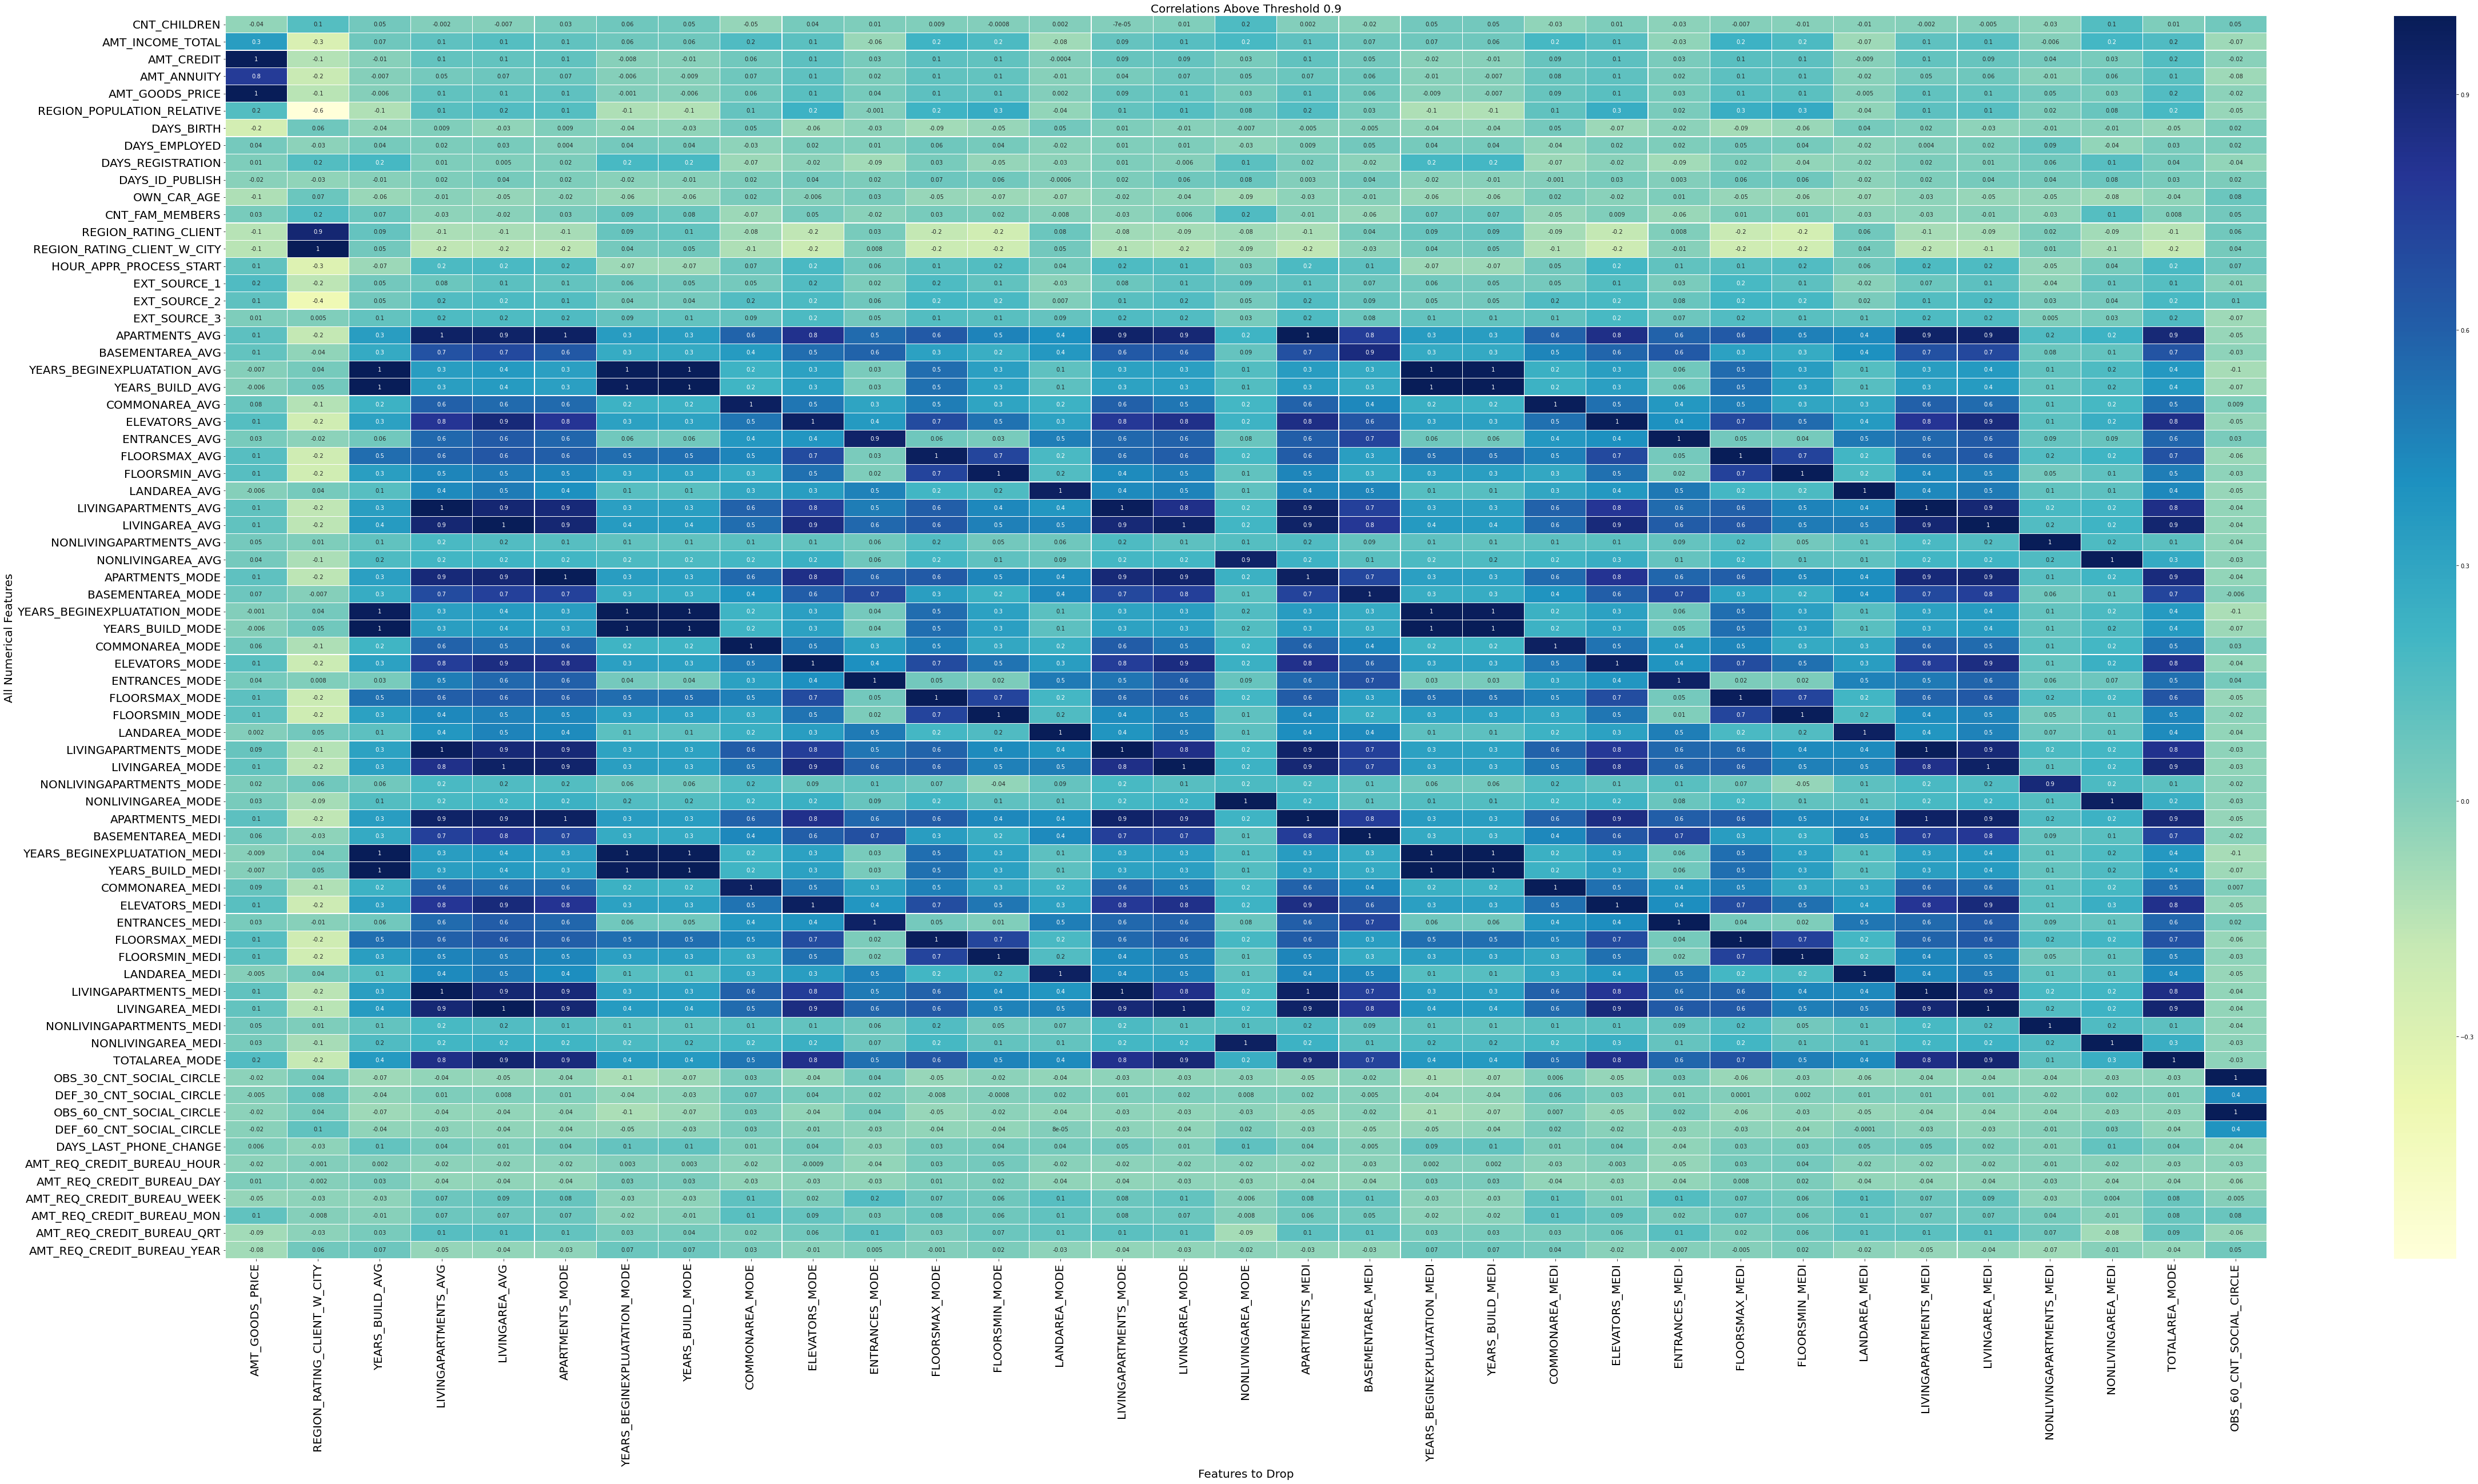

The essential selector took = 70.86481738090515 s
All importance selector took = 268.11367177963257 s


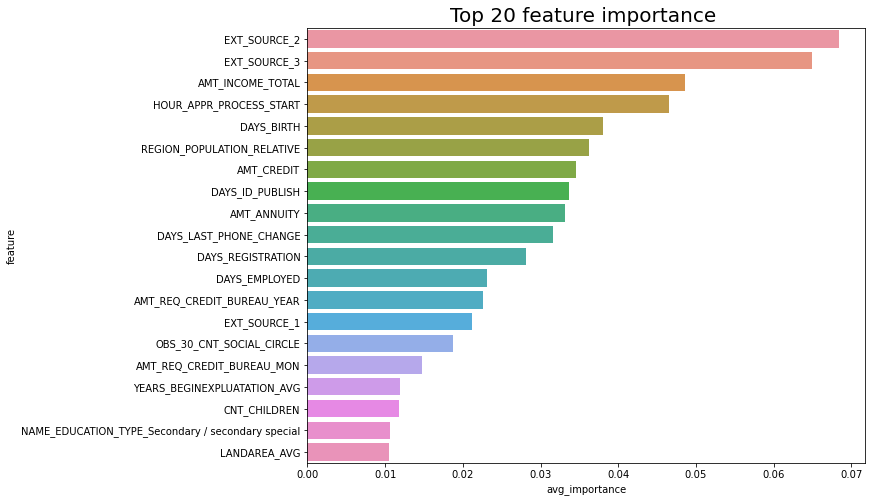

All ensemble selector took = 268.3230679035187 s
ensemble_drop::['FLAG_MOBIL', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_17', 'AMT_GOODS_PRICE', 'REGION_RATING_CLIENT_W_CITY', 'YEARS_BUILD_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'APARTMENTS_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'TOTALAREA_MODE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'OWN_CAR_AGE', 'COMMONAREA_AVG', 'FLOORSMIN_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_MODE', 'FONDKAPREMONT_MODE', 'FLAG_EMP_PHONE', 'FLAG_CONT_MOBILE', 

In [12]:
# ensemble_drop
to_drop = AutoFeatures.ensemble_drop(data, index_col=indexCol, label_col=labelCol, task=task, display=True, tracking=True)
print('ensemble_drop::{}'.format(to_drop))